# Generalized Linear Model

Even though the target, quality, is an ordinal feature, we can transform it into a categorical feature.  
For example, above 7, it's High Quality. Between 5 and 6, it's Moderate quality, and below 5 is Poor quality. 

In the initial case, I am comparing the predicted regression quality VS the true regression.

In [1]:
# Import libraries
import os 
import tempfile
import pickle
from pathlib import Path
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.metrics import accuracy_score, r2_score

from urllib.parse import urlparse

import mlflow
from google.cloud import storage

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [2]:
dfInput = pd.read_csv('../output/dataReady.csv', index_col = 'idx')

dfTrain = dfInput.loc[dfInput.Set == 'train']
dfVal = dfInput.loc[dfInput.Set == 'valid']

In [3]:
# "ANOVA" Test 
def calculate_nested_f_statistic(small_model, big_model):
    """Given two fitted GLMs, the larger of which contains the parameter space of the smaller, return the F Stat and P value corresponding to the larger model adding explanatory power"""
    addtl_params = big_model.df_model - small_model.df_model
    f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)
    df_numerator = addtl_params
    # use fitted values to obtain n_obs from model object:
    df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
    p_value = stats.f.sf(f_stat, df_numerator, df_denom)
    return (f_stat, p_value)

In [4]:
def glm_metrics(model, df, target):
    aic = model.aic
    results = pd.DataFrame(columns = ['True', 'Predicted', 'RMSE'])
    results['Predicted'] = np.around(model.predict(df))
    results['True'] = df[target]
    
    results['RMSE'] = np.sqrt((results['True'] - results['Predicted'])**2)
    results['MAE'] = np.abs((results['True'] - results['Predicted']))
    
    tab = pd.crosstab(results['True'], results['Predicted'])
    acc = accuracy_score(results['True'], results['Predicted'])
    
    rmse = results['RMSE'].mean()
    mae = results['MAE'].mean()
    
    return (aic, rmse, mae, acc, tab, results)

## Model Regressor

I use a poisson as the family in the GLM, due to it's discrete nature. 

### Run 1

In [6]:
## Model one
# https://stats.stackexchange.com/questions/190763/how-to-decide-which-glm-family-to-use
target = 'quality'
features = ['alcohol']

formula = f'{target}~{"+".join(features)}'

glm_model1 = sm.GLM.from_formula(formula, 
                                 data = dfTrain, 
                                 family=sm.families.Poisson()).fit()


(aic, rmse, mae, acc, tab, results) = glm_metrics(glm_model1, dfVal, 'quality')

In [ ]:
results = np.around(glm_model1.predict(dfVal))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.histplot(results, ax=ax1)
sns.kdeplot(results, ax=ax2, bw_method=0.8)

model_results = fig

In [ ]:
## Log Metrics and Model into MLFlow
with mlflow.start_run(run_name="GLM 1 Feature") as run:
    mlflow.log_param("Input Features", features)
    mlflow.log_metric("aic", aic)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("acc", acc)

    with tempfile.TemporaryDirectory() as temp_dir:
        temp_dir_path = Path(temp_dir)
        model_file_path = temp_dir_path / "model.pickle"
        dist_categories_path =  temp_dir_path / "output.png"
        model_results.savefig(dist_categories_path)
        with open(model_file_path, "wb") as f:
            pickle.dump(glm_model1, f)
        mlflow.log_artifact(model_file_path)
        mlflow.log_artifact(dist_categories_path)

In [7]:
print(glm_model1.summary())

model_results

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 1107
Model:                            GLM   Df Residuals:                     1105
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2032.8
Date:                Tue, 09 Nov 2021   Deviance:                       94.720
Time:                        22:05:18   Pearson chi2:                     93.4
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0269      0.124      8.259      0.0

NameError: name 'model_results' is not defined

### Run 2

In [ ]:
## Model two
# https://stats.stackexchange.com/questions/190763/how-to-decide-which-glm-family-to-use
target = 'quality'
features = ['alcohol', 'sulphates']

formula = f'{target}~{"+".join(features)}'

glm_model2 = sm.GLM.from_formula(formula, 
                                 data = dfTrain, 
                                 family=sm.families.Poisson()).fit()

(aic, rmse, mae, acc, tab, results) = glm_metrics(glm_model2, dfVal, 'quality')

In [ ]:
results = np.around(glm_model2.predict(dfVal))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.histplot(results, ax=ax1)
sns.kdeplot(results, ax=ax2, bw_method=0.8)

model_results = fig

In [ ]:
## Log Metrics and Model into MLFlow
with mlflow.start_run(run_name="GLM 2 Features") as run:
    mlflow.log_param("Input Features", features)
    mlflow.log_metric("aic", aic)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("acc", acc)

    with tempfile.TemporaryDirectory() as temp_dir:
        temp_dir_path = Path(temp_dir)
        model_file_path = temp_dir_path / "model.pickle"
        dist_categories_path =  temp_dir_path / "output.png"
        model_results.savefig(dist_categories_path)
        with open(model_file_path, "wb") as f:
            pickle.dump(glm_model2, f)
        mlflow.log_artifact(model_file_path)
        mlflow.log_artifact(dist_categories_path)

In [ ]:
glm_model2.summary()

In [ ]:
results = np.around(glm_model2.predict(dfVal))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.histplot(results, ax=ax1)
sns.kdeplot(results, ax=ax2, bw_method=0.8)

### Generic Run


In [5]:
## Model two
# https://stats.stackexchange.com/questions/190763/how-to-decide-which-glm-family-to-use
target = 'quality'
features = ['alcohol', 'sulphates','Q("volatile acidity")', 'Q("total sulfur dioxide")']

formula = f'{target}~{"+".join(features)}'

glm_model = sm.GLM.from_formula(formula, 
                                 data = dfTrain, 
                                 family=sm.families.Poisson()).fit()

/home/portugapt/.pyenv/versions/3.8.1/envs/LearnHub/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/portugapt/.pyenv/versions/3.8.1/envs/LearnHub/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/portugapt/.pyenv/versions/3.8.1/envs/LearnHub/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 1107
Model:                            GLM   Df Residuals:                     1102
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2025.4
Date:                Tue, 16 Nov 2021   Deviance:                       79.961
Time:                        10:27:40   Pearson chi2:                     79.0
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

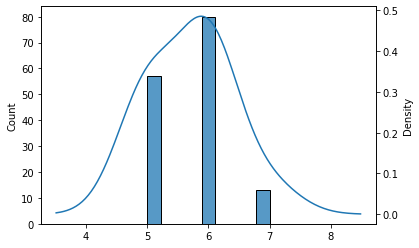

In [6]:
(aic, rmse, mae, acc, tab, results) = glm_metrics(glm_model, dfVal, 'quality')

results = np.around(glm_model.predict(dfVal))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.histplot(results, ax=ax1)
sns.kdeplot(results, ax=ax2, bw_method=0.8)

model_results = fig

print(glm_model.summary())

In [ ]:
## Log Metrics and Model into MLFlow
with mlflow.start_run(run_name="GLM N Features") as run:
    mlflow.log_param("Input Features", features)
    mlflow.log_metric("aic", aic)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("acc", acc)
    mlflow.log_metric("covariance type", acc)

    with tempfile.TemporaryDirectory() as temp_dir:
        temp_dir_path = Path(temp_dir)
        model_file_path = temp_dir_path / "model.pickle"
        dist_categories_path =  temp_dir_path / "output.png"
        model_results.savefig(dist_categories_path)
        with open(model_file_path, "wb") as f:
            pickle.dump(glm_model, f)
        mlflow.log_artifact(model_file_path)
        mlflow.log_artifact(dist_categories_path)

# Conclusions


I think this final model with 4 features isn't ideal, but for exercise effects, it's enough to have a baseline model.  
It had an accuracy of 0.633, which is fairly ok given the model. I am still not sure if the distribution and link functions are the most optimal for this kind of question.  
Lets look at some of the results in the test set.

(https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/)


In [30]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
# http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

In [28]:
GLM_confusion_matrix = confusion_matrix(dfVal['quality'], results)
GLM_confusion_matrix = GLM_confusion_matrix.T


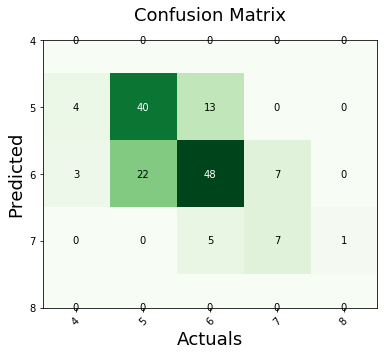

In [36]:
ig, ax = plot_confusion_matrix(conf_mat=GLM_confusion_matrix, 
                               figsize=(6, 6), cmap=plt.cm.Greens,
                              class_names = ('4','5','6','7','8'))
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predicted', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

We can see that overall the model is doing a good job. The classes it fails the most are 5-6 and 6-5 (actual-predict). They are also the most common classes. Even though quality 6 is highly common, there's apparently a clear distinction between wines of quality 6 and 7, since there's no high influx of quality 7 predictions, and quality 6 doesn't "drain" all quality 7 predictions.  
I think it's very likely, with more complex methods, to improve the results. 

The next step is to have a data-centric approach to this question. Lets improve the data quality!